<a href="https://colab.research.google.com/github/woneuy01/NLP_Jon/blob/master/bidirectional_lstm_sentiment_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bidirectional LSTM Sentiment Classifier

In this notebook, we use a *bidirectional* LSTM to classify IMDB movie reviews by their sentiment.

#### Load dependencies

In [0]:
import tensorflow
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Embedding, SpatialDropout1D, LSTM
from tensorflow.keras.layers import Bidirectional # new! 
from tensorflow.keras.callbacks import ModelCheckpoint
import os
from sklearn.metrics import roc_auc_score 
import matplotlib.pyplot as plt

#### Set hyperparameters

In [0]:
# output directory name:
output_dir = 'model_output/biLSTM'

# training:
epochs = 6
batch_size = 128

# vector-space embedding: 
n_dim = 64 
n_unique_words = 10000 
max_review_length = 200 # doubled! compare to lstm , bidirectional lstm max_length doubled
pad_type = trunc_type = 'pre'
drop_embed = 0.2 

# LSTM layer architecture:
n_lstm = 256 
drop_lstm = 0.2

#### Load data

In [0]:
(x_train, y_train), (x_valid, y_valid) = imdb.load_data(num_words=n_unique_words) # removed n_words_to_skip

17465344/17464789 [==============================] - 1s 0us/step


#### Preprocess data

In [0]:
x_train = pad_sequences(x_train, maxlen=max_review_length, padding=pad_type, truncating=trunc_type, value=0)
x_valid = pad_sequences(x_valid, maxlen=max_review_length, padding=pad_type, truncating=trunc_type, value=0)

#### Design neural network architecture

In [0]:
model = Sequential()

model.add(Embedding(n_unique_words, n_dim, input_length=max_review_length)) 
model.add(SpatialDropout1D(drop_embed))

model.add(Bidirectional(LSTM(n_lstm, dropout=drop_lstm)))

model.add(Dense(1, activation='sigmoid'))

In [0]:
# LSTM layer parameters double due to both reading directions
model.summary() 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 200, 64)           640000    
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 200, 64)           0         
_________________________________________________________________
bidirectional (Bidirectional (None, 512)               657408    
_________________________________________________________________
dense (Dense)                (None, 1)                 513       
Total params: 1,297,921
Trainable params: 1,297,921
Non-trainable params: 0
_________________________________________________________________


#### Configure model

In [0]:
model.compile(loss='binary_crossentropy', optimizer='nadam', metrics=['accuracy'])

In [0]:
modelcheckpoint = ModelCheckpoint(filepath=output_dir+"/weights.{epoch:02d}.hdf5")
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

#### Train!

In [0]:
# - with this toy dataset, the complex interplay of words over long sentence segments, won't be learned much
# - so our CNN picking up location-invariant segments of two to four words that predict review sentiment
# - these are simpler and so easier to learn from the data
# - CNN therefore outperforms on the IMDB data set
model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(x_valid, y_valid), callbacks=[modelcheckpoint])

Epoch 1/6
196/196 [==============================] - 23s 116ms/step - loss: 0.5577 - accuracy: 0.7176 - val_loss: 0.9746 - val_accuracy: 0.6143
Epoch 2/6
196/196 [==============================] - 22s 113ms/step - loss: 0.3481 - accuracy: 0.8600 - val_loss: 0.3780 - val_accuracy: 0.8478
Epoch 3/6
196/196 [==============================] - 22s 113ms/step - loss: 0.2727 - accuracy: 0.8926 - val_loss: 0.3155 - val_accuracy: 0.8709
Epoch 4/6
196/196 [==============================] - 22s 113ms/step - loss: 0.2403 - accuracy: 0.9083 - val_loss: 0.3201 - val_accuracy: 0.8691
Epoch 5/6
196/196 [==============================] - 22s 113ms/step - loss: 0.1998 - accuracy: 0.9257 - val_loss: 0.3222 - val_accuracy: 0.8700
Epoch 6/6
196/196 [==============================] - 22s 113ms/step - loss: 0.1742 - accuracy: 0.9360 - val_loss: 0.4296 - val_accuracy: 0.8584


#### Evaluate

In [0]:
model.load_weights(output_dir+"/weights.04.hdf5") 

In [0]:
y_hat = model.predict_proba(x_valid)

Instructions for updating:
Please use `model.predict()` instead.


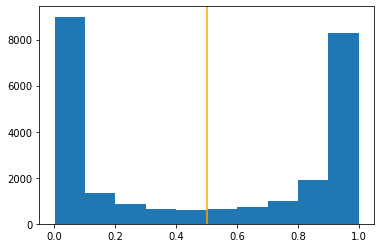

In [0]:
plt.hist(y_hat)
_ = plt.axvline(x=0.5, color='orange')

In [0]:
"{:0.2f}".format(roc_auc_score(y_valid, y_hat)*100.0)

'93.98'